In [53]:
using Pkg; Pkg.activate(".")
using TensorKit, Plots, JLD2

  Activating project at `~/work/GPU_TRG`
[ Info: Precompiling FileIOExt [f5f51d8f-5827-5d2e-939b-192fcd6ec70c] (cache misses: wrong dep version loaded (6), incompatible header (14))


In [41]:
## Model to simulate
const ising_βc = BigFloat(log(BigFloat(1.0) + sqrt(BigFloat(2.0))) / BigFloat(2.0))
function classical_ising_symmetric(β)
    x = cosh(β)
    y = sinh(β)

    S = ℤ₂Space(0 => 1, 1 => 1)
    T = zeros(Float64, S ⊗ S ← S ⊗ S)
    block(T, Irrep[ℤ₂](0)) .= [2x^2 2x * y; 2x * y 2y^2]
    block(T, Irrep[ℤ₂](1)) .= [2x * y 2x * y; 2x * y 2x * y]

    return T
end
classical_ising_symmetric() = classical_ising_symmetric(ising_βc)

classical_ising_symmetric (generic function with 2 methods)

In [42]:
# structure
mutable struct TRG
    T
end

# SVD decomposition
function SVD12(T, trunc)
    U, s, V, e = tsvd(T; trunc = trunc)
    return U * sqrt(s), sqrt(s) * V
end

# TRG algorithm
function step!(scheme::TRG, trunc)
    A, B = SVD12(scheme.T, trunc)
    Tp = transpose(scheme.T, ((2, 4), (1, 3)))
    C, D = SVD12(Tp, trunc)
    @plansor scheme.T[-1 -2; -3 -4] := D[-2; 1 2] * B[-1; 4 1] * C[4 3; -3] * A[3 2; -4]
    return scheme
end

# Normalization with trace norm
function normalize!(scheme)
    @tensor n = scheme.T[1 2; 2 1]
    scheme.T /= n
    return n
end

# Repeat for maxrg steps
function run!(scheme, trunc, maxrg)
    t = time()
    for i in 1:maxrg
        step!(scheme, trunc)
        n = normalize!(scheme)
    end
    return time() -t
end


run! (generic function with 1 method)

In [45]:
χ_list = 8:8:64
t_data = zeros(length(χ_list))
for (i,χ) in enumerate(χ_list)
    @info χ
    scheme = TRG(classical_ising_symmetric())
    t_data[i] = run!(scheme, truncdim(χ), 20)
end

[ Info: 8
[ Info: 16
[ Info: 24
[ Info: 32
[ Info: 40
[ Info: 48
[ Info: 56
[ Info: 64


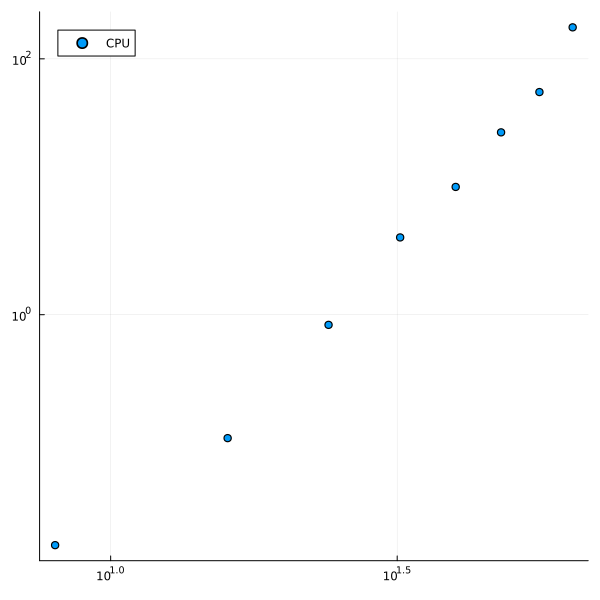

In [50]:
scatter(χ_list,t_data,xscale=:log10,yscale=:log10,label="CPU",size=(600,600))

In [54]:
save("time_data.jld2","chi",χ_list,"t",t_data)